# Load relevant info from motion energy fitting

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
# from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess

from himalaya.backend import set_backend

backend = set_backend("numpy", on_error="warn")

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nibabel import Nifti1Image
import cortex
import nibabel as nib
import os
opj = os.path.join

from matplotlib.colors import Normalize
def Vertex2D_fix(data1, data2, subject, cmap, vmin, vmax, vmin2, vmax2, roi_borders=None):
    #this provides a nice workaround for pycortex opacity issues, at the cost of interactivity    
    # Get curvature
    curv = cortex.db.get_surfinfo(subject)
    # Adjust curvature contrast / color
    curv.data = curv.data * .75 +0.1
    curv = cortex.Vertex(curv.data, subject, vmin=-1,vmax=1,cmap='gray')
    norm2 = Normalize(vmin2, vmax2)   
    vx = cortex.Vertex(data1, subject, cmap=cmap, vmin=vmin, vmax=vmax)
    # Map to RGB
    vx_rgb = np.vstack([vx.raw.red.data, vx.raw.green.data, vx.raw.blue.data])
    curv_rgb = np.vstack([curv.raw.red.data, curv.raw.green.data, curv.raw.blue.data])
    # Alpha mask
    alpha = np.clip(norm2(data2), 0, 1)
    display_data = (curv_rgb * (1-alpha)) + vx_rgb * alpha
    display_data /= 255
    if roi_borders is not None:
        display_data[:,roi_borders.astype('bool')] = 0
    
    # Create vertex RGB object out of R, G, B channels
    return cortex.VertexRGB(*display_data, subject) 


backend = set_backend("numpy", on_error="warn")

In [6]:
# Picking a random subject & path from AOT folder
sub = 1
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside2/model_sub{sub}_feature_motion32_trainses_1_Xcentered_True_Yzscore_True_Xstd_True_testinside.joblib"
model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1_2_3.joblib"
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1.joblib"
model = joblib.load(model_path)
cx_sub = f'sub-{sub:03d}'
deriv_dir = '/tank/shared/2024/visual/AOT/derivatives/'
param_path_dir = opj(deriv_dir, "prf", cx_sub)
fs_dir = opj(deriv_dir, "freesurfer")

# Weight from banded RR ...
primal_coef = model[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("(n_features, n_voxels) =", primal_coef.shape)
primal_coef = primal_coef.numpy() 
# max_index = np.argmax(primal_coef, axis=0)
# print("max_index.shape =", max_index.shape)
# Load the R2 scores for masking
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/R2_score_single_sub{sub}_motion_train_1_2_3_test_4.nii.gz"
R2 = nib.load(R2_file)
R2_data = R2.get_fdata()
print("R2_data shape:", R2_data.shape)
R2_data = np.transpose(R2_data, (2, 1, 0))
print("Transposed R2_data shape:", R2_data.shape)
ses=1
glmaccess = GLMSingleAccess()
mask = glmaccess.read_R2_mask(sub, ses=ses)
shape = glmaccess.read_shape(sub, ses=ses)
voxel_num = np.prod(shape)
flatten_mask = mask.flatten()
data_reshape = np.zeros(voxel_num)
r2_flat = R2_data.flatten()[flatten_mask]
r2_flat

/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(n_features, n_voxels) = torch.Size([11845, 336275])
R2_data shape: (81, 95, 101)
Transposed R2_data shape: (101, 95, 81)


array([0., 0., 0., ..., 0., 0., 0.], shape=(336275,))

In [49]:
# PRF parameters for comparison
prf_list = os.listdir(opj(param_path_dir, 'prf_fits', 'params'))
from dpu_mini.utils import *
import nibabel as nib
def get_prf_par(filt):
    nii = dag_find_file_in_folder(
        filt, 
        opj(param_path_dir, 'prf_fits', 'params'),
    )
    print(nii)
    return nib.load(nii).get_fdata().flatten()[flatten_mask]
gauss_pars = {}
for par in ['x', 'y', 'size', 'r2']:
    gauss_pars[par] = get_prf_par([par,'gauss', f'sub-{sub:03}', 'first'])
norm_pars = {}
for par in ['x', 'y', 'prf_size', 'r2', 'surr_size', 'surr_bsl', 'neur_bsl']:
    norm_pars[par] = get_prf_par([par,'norm', f'sub-{sub:03}', 'first'])


/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz
/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_y.nii.gz
/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_prf_size.nii.gz
/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz
/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz
/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/p

In [ ]:
['/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params.tsv', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_BDratio.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_bold_bsl.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_ecc.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_hrf_deriv.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_hrf_dsip.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_neur_bsl.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_polar.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_prf_ampl.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_prf_size.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_ampl.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_bsl.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_size.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz', '/tank/shared/2024/visual/AOT/derivatives/prf/sub-001/prf_fits/params/sub-001_ses-pRF_task-pRF_rec-nordicstc_run-firsthalf_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_y.nii.gz']


# Explore options for investigating the outputs

In [7]:
from AOTanalysis.voxelmotion.filter_info import RespEstimate
# Object class to do the estimation
# -> does some of the converting under the hood...
me_obj = RespEstimate(
    vhsize=(1080, 1920), # MAY NEED TO CHANGE THIS?
    fps=24,
    spatial_frequencies=[0, 2, 4, 8, 16, 32],
)

/tank/marcus/programs/AOT_analysis_mdag/AOTanalysis/voxelmotion/filter_info.py:73: RuntimeWarning: divide by zero encountered in divide
  vel = data['TF'] / data['SF']
/tank/marcus/programs/AOT_analysis_mdag/AOTanalysis/voxelmotion/filter_info.py:73: RuntimeWarning: invalid value encountered in divide
  vel = data['TF'] / data['SF']


In [8]:
r2_mask = r2_flat>0.1

## option [1] maximum weight

In [9]:
# weights n filters x n voxels 
# -> take the *maximum* per filter (literally just argmax)
max_w = me_obj.filter_max(w=primal_coef[:,r2_mask])
print(max_w)

            x         y       ecc       pol  SFimg        SF      size   TF  \
0   -3.005659 -1.502829  3.360429 -2.677945   16.0  1.397364  0.429380  0.0   
1    0.000000  0.000000  0.000000  0.000000    2.0  0.174671  3.435039  4.0   
2   -1.502829 -1.502829  2.125322 -2.356194   16.0  1.397364  0.429380  0.0   
3    6.011318 -1.502829  6.196324 -0.244979   32.0  2.794728  0.214690  0.0   
4    6.011318 -3.005659  6.720857 -0.463648   16.0  1.397364  0.429380  4.0   
..        ...       ...       ...       ...    ...       ...       ...  ...   
153 -1.502829  3.005659  3.360429  2.034444   32.0  2.794728  0.214690  0.0   
154 -6.011318 -3.757073  7.088832 -2.582993   32.0  2.794728  0.214690  4.0   
155  4.508488  1.502829  4.752364  0.321751   16.0  1.397364  0.429380  0.0   
156  6.011318  0.000000  6.011318  0.000000    4.0  0.349341  1.717519  0.0   
157  0.000000  0.000000  0.000000  0.000000    4.0  0.349341  1.717519  4.0   

       dir        vel  
0     90.0   0.000000  
1  

Could not find path for freeview, is freesurfer accessible from here?
Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE
SUBJECTS_DIR not found in os.environ
Adding empty string...


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x155324257cb0>)

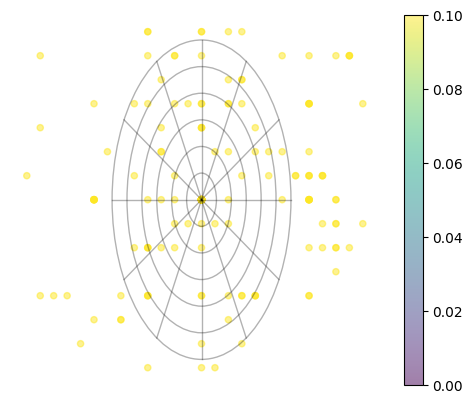

In [10]:
# Size vs eccentricity?
from dpu_mini.plot_functions import * 
fig, ax = plt.subplots(1,1)
dag_visual_field_scatter(
    max_w['x'],
    max_w['y'],
    dot_col=max_w['size'],
    dot_vmin=0, dot_vmax=.1,
    ax=plt.gca(),
    do_binning=False,
    dot_size=20
    # do_line=False, ÷do_corr=True,
)

(array([105.,   0.,  18.,   0.,  19.,   0.,   0.,   0.,   0.,  16.]),
 array([0.21468991, 0.53672478, 0.85875965, 1.18079452, 1.50282939,
        1.82486425, 2.14689912, 2.46893399, 2.79096886, 3.11300373,
        3.4350386 ]),
 <BarContainer object of 10 artists>)

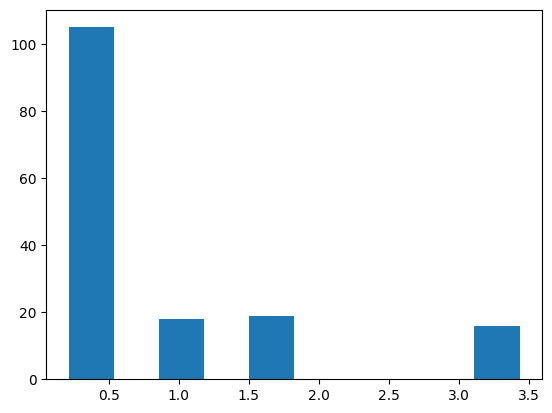

In [11]:
plt.hist(max_w['size'])

## option [2] weighted mean
Take the weighted mean of the filters
Best way to do this? Include negative? What about circular measures?...
Not too sure tbh....

At the moment doing this:


In [12]:
from AOTanalysis.voxelmotion.filter_info import RespEstimate
import inspect
print(inspect.getsource(RespEstimate.filter_weighted_mean))

    def filter_weighted_mean(self, w, params=None, option='clamp'):
        """
        Compute weighted means for a set of weight vectors.
        weights: array of shape (n_filters, N)
        Returns: DataFrame of shape (N, len(params))
        """        
        if w.ndim == 1:
            w = w[:, None]
        if w.shape[0] != self.n_filters:
            raise ValueError("Weights must have shape (n_filters, N)")
        if params is None:
            params = self.params_list
        # sum of weights per column
        # How to deal with negative weights? 
        # -> problem is you can get sumw nearly 0...
        if option=='clamp':
            # No negative weights
            w = np.maximum(w, 0)
            wsum = w.sum(axis=0)
        elif option=='L1':
            # Avoids wsum=0
            wsum = np.abs(w).sum(axis=0)
        elif option=='none':
            wsum = w.sum(axis=0)
        out = {}
        for p in params: 
            if p in ['x', 'y', 'SF', 'size', 'TF

In [13]:
mean_w = me_obj.filter_weighted_mean(primal_coef[:,r2_mask], option='L1')

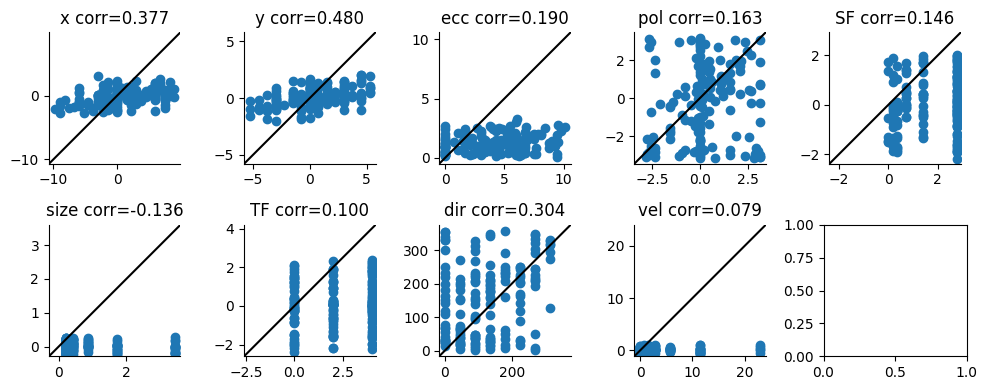

In [14]:
# How similar are they?
fig,ax = plt.subplots(2,5, figsize=(10,4))
ax = ax.flatten()
for i,k in enumerate(mean_w.keys()):
    ax[i].set_title(f'{k} ')
    dag_scatter(
        max_w[k],
        mean_w[k], 
        do_id_line=True, 
        do_corr=True, 
        ax=ax[i],
    )
fig.set_tight_layout('tight')

## option [3] Nishimoto -> (see supplementary for how they create there figures)
#### For x,y,size
* create dynamic white noise stimulus; squares gridding the screen (i.e., 17 x 17)
* compute model responses to these "movies". Per voxel you have a n x n response matrix (this is used for plotting too I think)
* fit a gaussian to this n x n response matrix. This gives you the vx, x,y,size etc...

#### For TF,SF,velocity 
* create drifting gratings at the TF, SF and directions of the pyramid (SF=0,2,...; TF=0,2,...)
* compute "voxel" responses to those "movies"
* Take the mean across the TF x SF combinations (for plot)
* Velocity = peak TF / peak SF

##### make the movies -> project through the pyramid from pymoten

In [20]:
# First we need to make the movies & project them to the filters
# How much downsampling? How many frames? Idk...
# This takes time - so best to run it somewhere else and do it again...
ds = 10
f_pre = ''
file = f'./{f_pre}ns_space{ds}'
if not os.path.exists(file):
    me_obj._stim_make_space(
        grid_size=(17,17), # what is the size of the x,y grid we are making? Nishimoto says 17 x17..
        downsample=ds, # How much to downsample
        )
    with open(file, 'wb') as f:
        pickle.dump(me_obj.stim_space, file=f)
else:
    with open(file, 'rb') as f:
        me_obj.stim_space = pickle.load(f)

file = f'./{f_pre}ns_gray{ds}'
if not os.path.exists(file):
    # They also compute the responses to "gray" object...
    # I don't know if this matters
    me_obj._stim_make_gray(downsample=ds)
    with open(file, 'wb') as f:
        pickle.dump(me_obj.stim_gray, file=f)
else:
    with open(file, 'rb') as f:
        me_obj.stim_gray = pickle.load(f)

# ds = 60
file = f'./{f_pre}ns_tfsf{ds}'
if not os.path.exists(file):
    me_obj._stim_make_tfsf(downsample=ds, dir_list=np.linspace(0,360,5)[:-1])
    with open(file, 'wb') as f:
        pickle.dump(me_obj.stim_tfsf, file=f)
else:
    with open(file, 'rb') as f:
        me_obj.stim_tfsf = pickle.load(f)



In [89]:

import numpy as np
from scipy.optimize import curve_fit

def fit_sym_gaussians_with_offset(
    X,
    Y,
    Z,
):
    """
    Fit a symmetric 2D Gaussian + constant offset to each slice Z[:,:,k]
    and compute R² for each fit.

    Parameters
    ----------
    X : ndarray, shape (n, m)
        x-coordinate at each pixel.
    Y : ndarray, shape (n, m)
        y-coordinate at each pixel.
    Z : ndarray, shape (n, m, c)
        Measured intensities.

    Returns
    -------
    centers : ndarray, shape (c, 2)
        Fitted (x0_k, y0_k) for each slice k.
    sigmas : ndarray, shape (c,)
        Fitted sigma_k for each slice.
    amplitudes : ndarray, shape (c,)
        Fitted A_k for each slice.
    offsets : ndarray, shape (c,)
        Fitted offset (constant background) for each slice.
    r2s : ndarray, shape (c,)
        R² of each fit (coefficient of determination). NaN if fit failed.
    """
    # Number of slices
    _, _, num_slices = Z.shape

    # Pre-allocate return arrays
    centers   = np.zeros((num_slices, 2), dtype=float)
    sigmas    = np.zeros(num_slices, dtype=float)
    amplitudes = np.zeros(num_slices, dtype=float)
    offsets   = np.zeros(num_slices, dtype=float)
    r2s       = np.zeros(num_slices, dtype=float)

    # Flattened coordinates (same for every slice)
    X_flat = X.ravel()
    Y_flat = Y.ravel()

    # Define a symmetric 2D Gaussian + constant offset
    def _gaussian_2d(coords, x0, y0, sigma, A, offset):
        x, y = coords
        exponent = -((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)
        return A * np.exp(exponent) + offset

    # Determine bounds for (x0, y0, sigma, A, offset)
    xmin, xmax = np.min(X_flat), np.max(X_flat)
    ymin, ymax = np.min(Y_flat), np.max(Y_flat)
    # sigma > 0, A >= 0, offset unbounded
    lower_bounds = [xmin, ymin, 0.0, 0.0, -np.inf]
    upper_bounds = [xmax, ymax, np.inf, np.inf, np.inf]

    for k in range(num_slices):
        Zk = Z[:, :, k]
        Z_flat = Zk.ravel()

        # Initial guesses:
        # - x0, y0 at the coordinate of the maximum intensity
        idx_max = np.argmax(Z_flat)
        x0_init = X_flat[idx_max]
        y0_init = Y_flat[idx_max]

        # - sigma: roughly 1/4 of the range of X (or Y)
        sigma_init = 0.25 * max(xmax - xmin, ymax - ymin)

        # - A: max minus min of Zk
        A_init = np.max(Z_flat) - np.min(Z_flat)

        # - offset: minimum of Zk
        offset_init = np.min(Z_flat)

        p0 = [x0_init, y0_init, sigma_init, A_init, offset_init]

        try:
            popt, _ = curve_fit(
                _gaussian_2d,
                (X_flat, Y_flat),
                Z_flat,
                p0=p0,
                bounds=(lower_bounds, upper_bounds),
                maxfev=10000
            )
            x0_fit, y0_fit, sigma_fit, A_fit, offset_fit = popt

            # Compute predicted Z for R² calculation
            Z_pred = _gaussian_2d((X_flat, Y_flat), *popt)

            # SS_res and SS_tot
            ss_res = np.sum((Z_flat - Z_pred) ** 2)
            z_mean = np.mean(Z_flat)
            ss_tot = np.sum((Z_flat - z_mean) ** 2)

            # In case Z is constant (ss_tot == 0), define R2 = 1 if fit reproduces that constant
            if ss_tot == 0:
                # If all Z_flat are identically equal, then the best-fit offset ≈ that constant
                # We set R² = 1 if the model reproduces mean exactly, else R² = 0
                if np.allclose(Z_flat, Z_pred, atol=1e-8):
                    r2_fit = 1.0
                else:
                    r2_fit = 0.0
            else:
                r2_fit = 1.0 - (ss_res / ss_tot)

        except RuntimeError:
            # If fit fails, fill with NaNs
            x0_fit = y0_fit = sigma_fit = A_fit = offset_fit = np.nan
            r2_fit = np.nan

        centers[k, 0] = x0_fit
        centers[k, 1] = y0_fit
        sigmas[k]    = sigma_fit
        amplitudes[k] = A_fit
        offsets[k]   = offset_fit
        r2s[k]       = r2_fit

    return centers, sigmas, amplitudes, offsets, r2s


In [ ]:
wnoise_resp_pos = wnoise_resp.copy()
wnoise_resp_pos[wnoise_resp_pos<0] = 0
sgauss = fit_sym_gaussians_with_offset(
    X=idx['x'], Y=idx['y'], Z=wnoise_resp
    
)

In [160]:
wnoise_resp[wnoise_resp<0] = 0.0

In [146]:
print(np.where(beep[-2]>0.7))
# print(i)
print(np.where(r2_mask)[0][3])

(array([], dtype=int64),)
2332


In [149]:
beep[-2].argsort(-1)

array([ 53, 104, 105,   1, 126,  59,  96, 102,   5,  14, 119, 136,  83,
       113,  91,   3,   8, 142,  45,  11,  27,  73, 131,  95, 101,  77,
       100, 118,  33,  88, 151,  25, 106,  98,  78,  72, 103,  55, 155,
        87,  35,  46,  52, 122,  60, 149, 108,  28, 117,  13,   7,  84,
        90, 156,  18, 125, 144, 148,  50,  10,   9, 150, 127,  82, 141,
        24,  54,  99,  66,  74,  21, 128, 115, 107,  97,  49, 143,  37,
        19, 154,  40, 140,  42, 157,  92,  63, 137,  62,  39,  23,   4,
       134,  85,  22, 130,  70,  79, 129, 109,  80, 145,   0, 153,  44,
        94, 116,  48,  20,  36, 110,  81,  16,  75, 146,  31,   2,  47,
        29, 124,  34,  12,  86,  17,  26, 133, 135,  89,  93, 121,  67,
        15, 132, 152,  71, 138,  64, 123, 139,   6, 147,  38,  76,  69,
        51,  68,  32, 120,  43,  30, 112,  61,  65, 114,  58,  56,  57,
        41, 111])

In [140]:
pm_mask = primal_coef[:,r2_mask]

array([-4.05241077,  4.31524473])

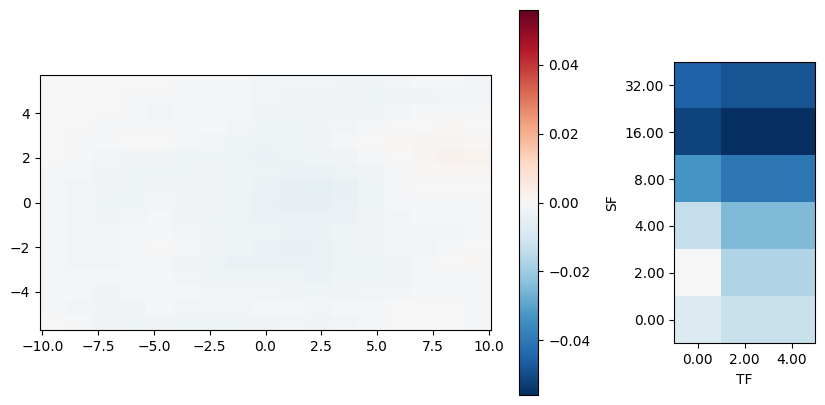

In [152]:
i = 40
me_obj.nish_stim_plot(pm_mask[:,i])
beep[0][i,:] #.min(axis=0)

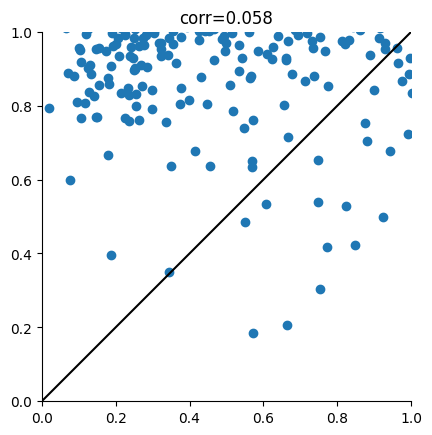

In [181]:
r22_mask = r2_mask & (gauss_pars['r2']>0.1)

dag_scatter(
    gauss_pars['size'][gr2_mask],
    sgauss[1], do_id_line=True, do_corr=True,
    x_lim=[0,1],y_lim=[0,1]
)

In [163]:
gr2_mask = gauss_pars['r2']>0.1
gr2_mask.sum()

np.int64(5967)

In [164]:
# matrix of 17 x 17 x n voxel: representing the weighted sum 
# with respect to the "movies" we made (gaussian white noise)
# -> this should give us x,y,size
gr2_mask = gauss_pars['r2']>0.1
wnoise_resp,idx = me_obj._pref_space(w=primal_coef[:,gr2_mask], return_idx=True)

# -> from here we have several options (again) to extract, x,y,size...
# [a] As in nishimoto -> fit a 2d isotropic gaussian... (how exactly though?) Maybe with

In [ ]:
# matrix of n TF x n SF x n voxel: representing the weighted sum 
# with respect to the "movies" we made (drifting gratings)
wtfsf_resp = me_obj._pref_tfsf(w=primal_coef[:,r2_mask])

(6, 3, 158)


In [ ]:
# matrix of n directions  x n voxel: representing the weighted sum 
# with respect to the "movies" we made (drifting gratings)
wdir_resp = me_obj._pref_dir(w=primal_coef[:,r2_mask])

##### use this to generate nishimoto style figure per voxel

(6, 3, 1)


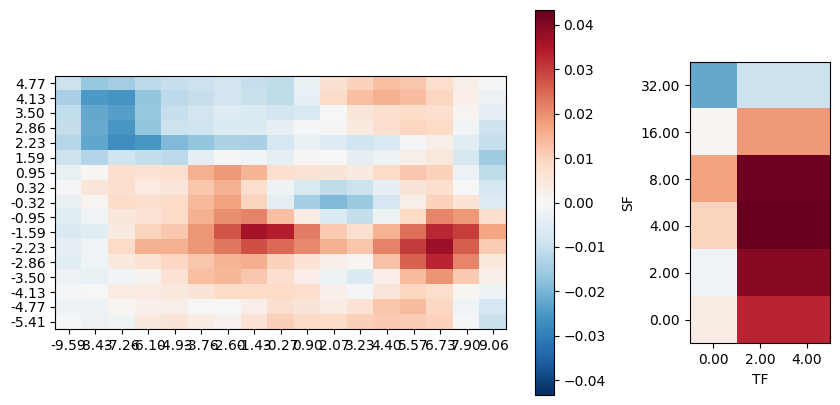

In [21]:
me_obj.nish_stim_plot(w=primal_coef[:,0])

(6, 3, 1)
(6, 3, 1)
(6, 3, 1)
(6, 3, 1)
(6, 3, 1)


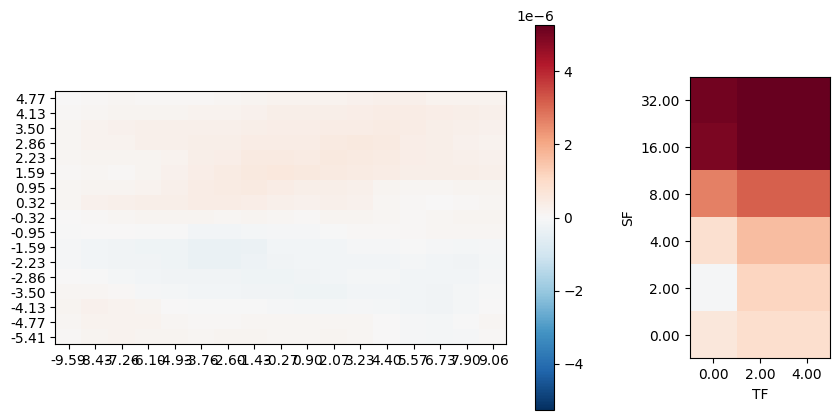

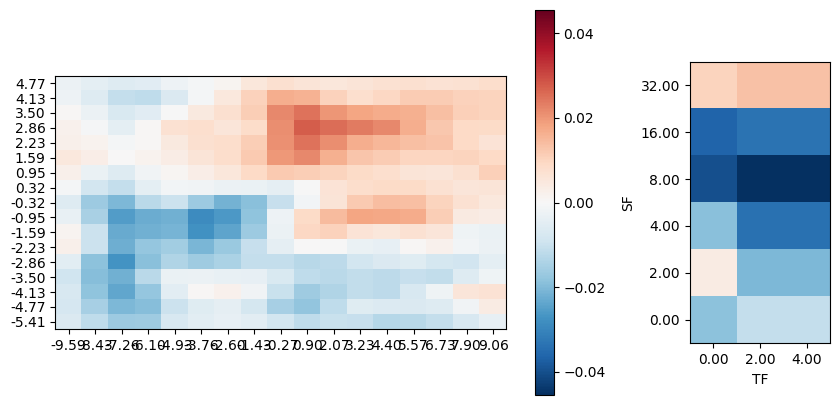

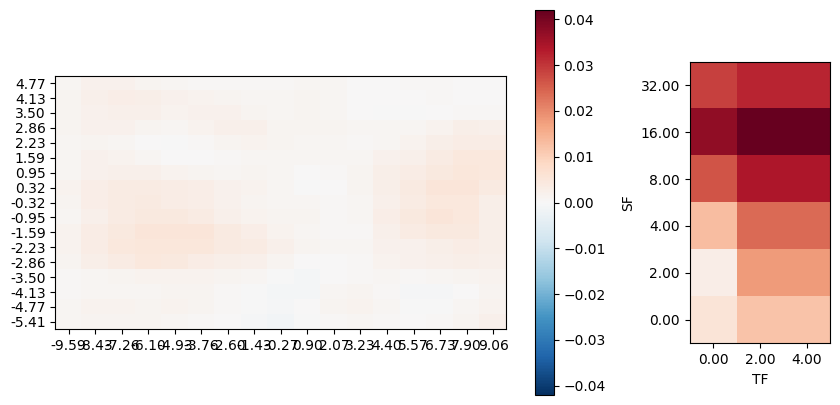

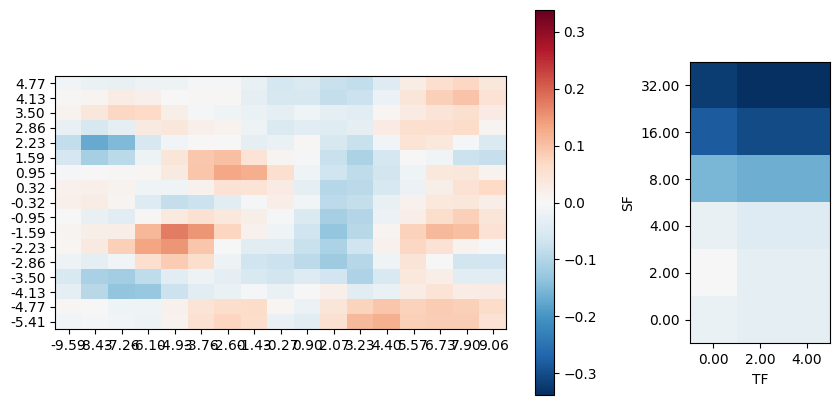

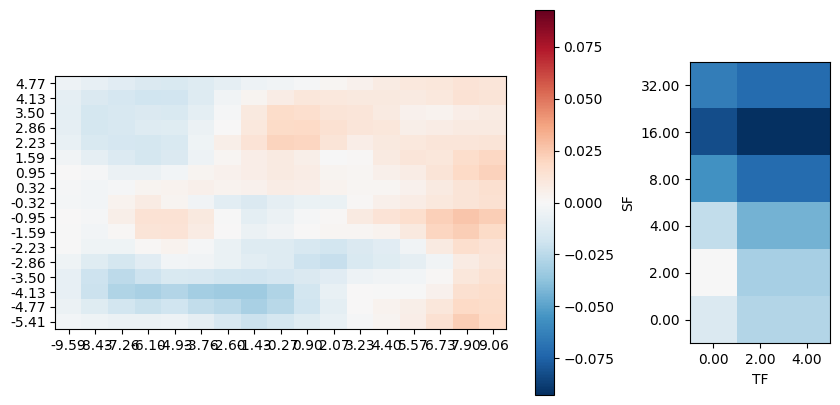

In [39]:
a =  np.argsort(r2_flat)[-1::-1]
for i in a[:5]:
    ns.nish_stim_plot(primal_coef[:,i])

In [177]:
space_mat = ns._pref_space(primal_coef)

In [49]:
beep = np.argmax(space_mat, axis=0)

In [178]:
# Get indices of maximum value for each slice
max_xy = [np.argmax(space_mat[:,:,i].flatten()) for i in range(space_mat.shape[-1])] 
# Now the 
# max_xy will contain the (x,y) coordinates for the maximum value in each slice
# max_xy[:, 0] contains all x coordinates 
# max_xy[:, 1] contains all y coordinates

In [179]:
max_x = [ns.stim_space['filt_x'][i] for i in max_xy]
max_y = [ns.stim_space['filt_y'][i] for i in max_xy]

In [180]:
ecc,pol = ns._cart2pol(max_x, max_y)

In [72]:
wm = ns.filter_weighted_mean(primal_coef)

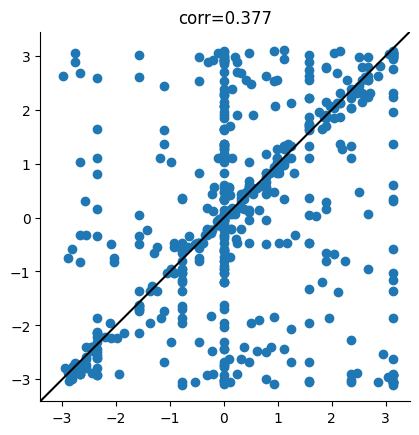

In [191]:
from dpu_mini.plot_functions import *
r2_mask = r2_flat>0.05
dag_scatter(
    wmax['pol'][r2_mask],
    np.array(pol)[r2_mask],
    do_id_line =True, do_corr=True,
)

In [86]:
dir_pref = ns._pref_dir(primal_coef)

(4, 336275)


In [90]:
dir_pref_id = np.argmax(dir_pref, axis=0)
dir_pref_1 = [ns.stim_tfsf['dir'][i] for i in dir_pref_id]

(-10.0, 10.0)

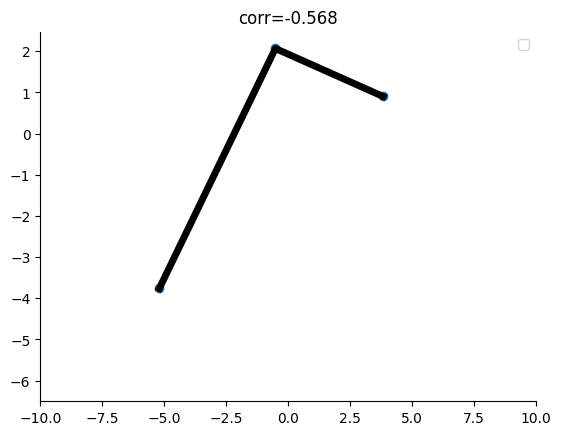

In [128]:
r2_mask = r2_flat>0.3
dag_scatter(
    wm['x'][r2_mask], 
    np.array(max_x)[r2_mask],
    # np.array(dir_pref_1)[r2_mask],
    do_corr=True,
    do_line=True,
    bins=np.linspace(-10,10,10) 
)
plt.gca().set_xlim(-10,10)

# PRF parameters for comparison


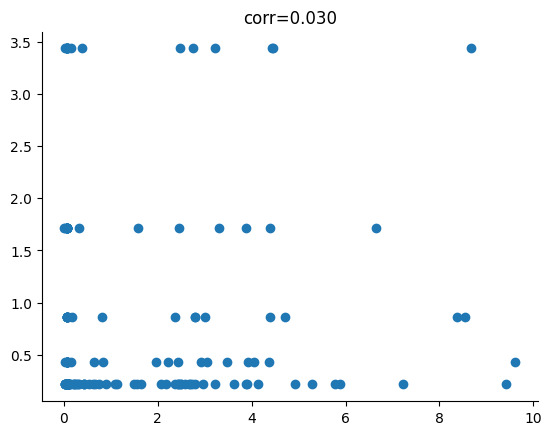

In [59]:
dag_scatter(
    gauss_pars['size'][r2_mask],
    max_w['size'], 
    # do_id_line=True, 
    do_corr=True, 
)